In [ ]:
"""

Connect to S3 Storage

"""

In [1]:
import boto3
#Set up boto3 so all buckets can be accessed.

os.environ['AWS_DEFAULT_REGION'] = 'us-east-2'

s3 = boto3.resource(
    service_name='s3',
    region_name=os.getenv('AWS_DEFAULT_REGION'),
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY')
)

#Print all buckets. This will be skipped over in order to prevent bucket names being public.
#for bucket in s3.buckets.all():
#    print(bucket.name)

In [ ]:
"""

STOCK DATA EXTRACTER PER 5 MINUTES PIPELINE

"""

In [4]:
import boto3
import pandas as pd
import yfinance as yf
from io import StringIO
import requests

#stock_refresh: Downloads from yfinance every 5 minutes, which then localizes the index's time

def stock_refresh(symbol, interval_time):
        new_df = yf.download(tickers=symbol, interval="5m", period="1d")
        new_df.index = new_df.index.tz_localize(None)
        return new_df
    
#update_stock: Merges new and old data by comparing localized indexes, which then updates the dtaframe

def update_stock(df, new_df):
        new_df_filtered = new_df[~new_df.index.isin(df.index)]
        df_final = pd.concat([df, new_df_filtered])
        return df_final

#pull_from_database: Used to pull the specific object from the bucket, which then has its index converted to datetime for further manipulation

def pull_from_database():
        yfinance_bucket = os.getenv('YFINANCE_DATA_BUCKET')
        obj = s3.Bucket(yfinance_bucket).Object('aapl_stock.csv').get()
        updated_df = pd.read_csv(obj['Body'], index_col="Datetime")
        return updated_df
    
#save_to_database: Saves to s3 bucket by storing dataframe in a csv buffer, which then uploads the file
def save_to_database(df):
        csv_buffer = StringIO()
        df.to_csv(csv_buffer, index=True)
        yfinance_bucket = os.getenv('YFINANCE_DATA_BUCKET')
        s3.Bucket(yfinance_bucket).put_object(Key='aapl_stock.csv', Body=csv_buffer.getvalue())

#calculate_rsi: Calculates the RSI
def calculate_rsi(df, window_size = 14):
    df.index = pd.to_datetime(df.index)
    df['date'] = df.index.day #Split dataframe per day to calculate intraday RSI
    
    #Additional functionused to set rolling values to compute RSI
    def calc_rsi_roll(set):
        delta = set['Close'].diff().fillna(0) #Calculate diff between curr + prev prices
            
        gain = delta.where(delta>0.0)
        loss = -delta.where(delta<0.0)
        
        #Assess the average gains and loss through delta, to where it is then averaged by window size (14 candles)
        
        avg_gain = gain.rolling(window=window_size, min_periods=1).apply(lambda x: x[x > 0].mean(), raw=False).fillna(0)
        avg_loss = loss.rolling(window=window_size, min_periods=1).apply(lambda x: x[x > 0].mean(), raw=False).fillna(0)

        rs = avg_gain/avg_loss #Compute the rs in the gain and loss
        
        set['Relative Strength Index'] = (100-(100/(1+(rs)))) #Calculate RSI

        set['Relative Strength Index'] = set['Relative Strength Index'].fillna(0) #Fill all null values with 0 as the averages were not computed
                   
        return set
        
    df = df.groupby('date', group_keys= False).apply(calc_rsi_roll)#group all by each day's date, which is then dropped
    df = df.drop(columns='date')#This means that each window calculates rolling averages per day rather than every day until recent
    return df
        
def ma_calculations(df, window_size=20):
    df.index = pd.to_datetime(df.index, errors='coerce')
    df['date'] = df.index.day #Split per day
        
    def calculate_nma_roll(set): #Calculate intraday rolling averages per window size
        set['Normal Moving Average'] = set['Close'].rolling(window=window_size).mean()
        return set

    def calculate_ema_roll(set): #Calculate intraday exponential per window size, with a smaller candle set
        set['Exponential Moving Average'] = set['Close'].ewm(span=10, min_periods=10, adjust=False).mean()
        return set

    df = df.groupby('date', group_keys=False).apply(calculate_nma_roll)
    df = df.groupby('date', group_keys=False).apply(calculate_ema_roll)#Calculate both grouped per day, rather than all until recent
    df = df.drop(columns='date')
    return df

def live_pipeline(): #Function which combines all aspects to extract, transform, and then load this data to a S3 bucket
    df = pull_from_database()
    new_df = stock_refresh("AAPL", interval_time="5m")
    updated_df = update_stock(df, new_df)
    updated_df = ma_calculations(updated_df)
    updated_df = calculate_rsi(updated_df)
    save_to_database(updated_df)
        
    print(updated_df.tail())

live_pipeline()

[*********************100%***********************]  1 of 1 completed


                           Open        High         Low       Close  \
Datetime                                                              
2025-01-23 15:35:00  222.660004  222.660004  222.419998  222.585007   
2025-01-23 15:40:00  222.585007  222.678497  222.300003  222.360001   
2025-01-23 15:45:00  222.369995  222.610001  222.369995  222.610001   
2025-01-23 15:50:00  222.604996  223.179993  222.550003  222.854797   
2025-01-23 15:55:00  222.854996  223.649994  222.809998  223.649994   

                      Adj Close   Volume  Normal Moving Average  \
Datetime                                                          
2025-01-23 15:35:00  222.585007   403993             222.784966   
2025-01-23 15:40:00  222.360001   564990             222.755431   
2025-01-23 15:45:00  222.610001   556184             222.755931   
2025-01-23 15:50:00  222.854797  1510111             222.766671   
2025-01-23 15:55:00  223.649994  3429201             222.822671   

                     Exponential

In [ ]:
"""

PREPROCESSING/SCALING DATA: SVM + LSTM LOAD FUNCTION

"""

In [8]:
from tensorflow.keras.models import load_model
from io import BytesIO, StringIO
import joblib
import boto3

#load_from_s3 : Load from S3 function
def load_from_s3(bucket_name, file_name):
    if not file_name.endswith(('.npy', '.pkl', '.csv', '.keras')): #If the file is not a valid type
        raise ValueError(f"Unsupported file type: {file_name}")#Raise error
    try:
        with BytesIO() as buffer:#Or else, establish a buffer
            s3.Bucket(bucket_name).download_fileobj(file_name, buffer) #Then, grab the file object from bucket
            buffer.seek(0)
            
            if file_name.endswith('.keras'): #Depending on the ending of file name, load in appropiate manner
                with tempfile.NamedTemporaryFile(suffix='.keras') as temp_model_file:
                    temp_model_file.write(buffer.read())
                    temp_model_file.flush()#Use tempfile to load .keras model
                    loaded_model = load_model(temp_model_file.name)
                return loaded_model

            elif file_name.endswith('.npy'): #Use an np.load for .npy
                return np.load(buffer)
                
            elif file_name.endswith('.pkl'): #Use a joblib for pkl
                return joblib.load(buffer)

            else:
                return pd.read_csv(buffer) #Or else, it must be csv so read csv
                
    except Exception as e:
        raise RuntimeError(f"Failed to load {file_name} from {bucket_name}: {e}") #If none, load this exception as an error


def load_variables_from_s3(file_dict): #Load all from the file dictionary to then call the function above to load in chain
    return {
        var_name: load_from_s3(bucket, filename)
        for var_name, (bucket, filename) in file_dict.items()
    }

In [6]:
import tempfile
import numpy as np
import pandas as pd
import joblib
from io import BytesIO
from tensorflow.keras.models import save_model

#Same thing as above, except you just save

def upload_to_s3(object, bucket_name, file_name):
    if not file_name.endswith(('.npy', '.pkl', '.csv', '.keras')):
        raise ValueError(f"Unsupported file type: {file_name}")

    try:
        with BytesIO() as buffer:
            
            if file_name.endswith('.keras'):
                with tempfile.NamedTemporaryFile(suffix='.keras') as temp_model_file:
                    save_model(object, temp_model_file.name)
                    temp_model_file.flush()
                    buffer.write(temp_model_file.read())
                
            elif file_name.endswith('.npy'):
                np.save(buffer, object)
                    
            elif file_name.endswith('.pkl'):
                joblib.dump(object, buffer)
                
            else:
                object.to_csv(buffer, index=False)

            buffer.seek(0) #load buffer at end this time to then upload to bucket
            s3.Bucket(bucket_name).put_object(Key=file_name, Body=buffer.getvalue())

    except Exception as e:
        raise RuntimeError(f"Failed to upload {file_name} to {bucket_name}: {e}")

def save_variables_to_s3(file_dict): #Save chain from dictionary items
        for var_name, (object, bucket, filename) in file_dict.items():
            upload_to_s3(object, bucket, filename)

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
from io import BytesIO

def create_metrics_csv(mse, rmse, next_price_prediction): #Create csv dataframe to store metrics
    new_entry = pd.DataFrame({
        'Timestamp': [datetime.now()],
        'MSE': [mse],
        'RMSE': [rmse],
        'Next_Price_Prediction': [next_price_prediction]
    })
    return new_entry

def update_metrics_on_s3(bucket_name, s3_filename, new_entry,): #If the data exists, load it and concat new metrics
    try:
        existing_data = load_from_s3(bucket_name, s3_filename)
    except RuntimeError:
        existing_data = new_entry #Or else, create new data from this entry
        
    updated_data = pd.concat([existing_data, new_entry], ignore_index=True) #Concat and then update their data

    save_variables_to_s3({
        'logged_metrics': (updated_data, bucket_name, s3_filename) #Then use s3 bucket to upload
    })

In [ ]:
"""

LIVE CALCULATION OF DATA SET PIPELINE

"""

In [10]:
import boto3
import pandas as pd
from io import StringIO
import requests
import time

s3 = boto3.resource('s3')

def process_from_database(df):
    normal_window = 9  #Fast
    slow_d = 3  #Slow
    necessary_columns = ['Close', 'High', 'Low', 'Volume']  # needed columns

    if not all(col in df.columns for col in necessary_columns):
        print(f"Error: Missing one or more required columns: {necessary_columns}")
        return None

    #Nma + Ema calculations
    def ma_calculations(df, window_size=5):
        df.index = pd.to_datetime(df.index, errors='coerce')
        df['date'] = df.index.day #Per day split so the first 5 will be of NA

        def calculate_nma_roll(set):
            set['Normal Moving Average'] = set['Close'].rolling(window=window_size).mean() #calculate rolling set per window size
            return set

        def calculate_ema_roll(set):
            set['Exponential Moving Average'] = set['Close'].ewm(span=10, adjust=False).mean()
            return set #Calculates all past the last 10 index, with the rest being dropped

        df = df.groupby('date', group_keys=False).apply(calculate_nma_roll)
        df = df.groupby('date', group_keys=False).apply(calculate_ema_roll)#Run function through per day organization
        df = df.drop(columns='date')
        return df

    df = ma_calculations(df)

    #Rsi calc
    def calculate_rsi(df):
        df['Close'] = df['Close'].fillna(0)
        delta = df['Close'].diff()
        average_gain = (delta.where(delta > 0, 0)).rolling(window=normal_window).mean()
        average_loss = (-delta.where(delta < 0, 0)).rolling(window=normal_window).mean()
        rs = average_gain / average_loss
        df['Relative Strength Index'] = 100 - (100 / (1 + rs))
        return df

    df = calculate_rsi(df)

    #Target shift for rfm
    df["Shift For Target"] = df['Close'].shift(-1)
    df["Target"] = (df["Shift For Target"] > df['Close']).astype(int)

    #Max + min rolling windows
    df['High_N'] = df['High'].rolling(window=normal_window).max()
    df['Low_N'] = df['Low'].rolling(window=normal_window).min()

    #Stochastic oscillator
    df['%K Fast'] = (df['Close'] - df['Low_N']) * 100 / (df['High_N'] - df['Low_N'])
    df['%D Slow'] = df['%K Fast'].rolling(window=slow_d).mean()

    #Williams %R
    df['Williams R%'] = -100 * ((df['High_N'] - df['Close']) / (df['High_N'] - df['Low_N']))

    #MACD
    df['MACD'] = df['Exponential Moving Average'] - df['Normal Moving Average']

    #Price rate of change
    df["shift_one_forward"] = df['Close'].shift(1)
    df["Price Rate of Change"] = ((df['Close'] - df["shift_one_forward"]) / df["shift_one_forward"]) * 100

    #On balance volume
    df["Variation"] = df["Close"].diff()
    df["On Balance Volume"] = 0
    for i in range(1, len(df)):
        daily_change = df["Variation"].iloc[i]#Subtract or add the day's volumne dependent on if closing price increased or decreased
        volume = df["Volume"].iloc[i] if daily_change > 0 else -df["Volume"].iloc[i] if daily_change < 0 else 0
        df["On Balance Volume"].iloc[i] = df["On Balance Volume"].iloc[i - 1] + volume

    #Standard deviation and bollinger bands, upper and lower
    df['Moving Standard Deviation'] = df['Close'].rolling(window=5).std()
    df['Upper Band'] = df['Normal Moving Average'] + 2 * df['Moving Standard Deviation']
    df['Lower Band'] = df['Normal Moving Average'] - 2 * df['Moving Standard Deviation']

    #% change, moving average, volatility calculations, momentum etc.
    df['Percentange_Change'] = (df['Close'] - df['Close'].shift(1)) * 100 / df['Close'].shift(1)
    df['Moving_Ave'] = df['Close'].rolling(window=12).mean()
    df['Close_To_moving_AVG'] = df['Close'] / df['Moving_Ave']
    df['Price_Range_Normalization'] = (df['Close'] - df['Low_N']) / (df['High_N'] - df['Low_N'])
    df['volatility'] = df['Close'].rolling(window=normal_window).std()
    df['momentum'] = df['Close'] - df['Close'].shift(normal_window)

    #Adx calculations
    def get_adx(high, low, close, window):
        plus_dm = high.diff().clip(lower=0)#positive VS negative directional movement
        minus_dm = low.diff().clip(upper=0).abs()
        atr = pd.concat([high - low, (high - close.shift(1)).abs(), (low - close.shift(1)).abs()], axis=1).max(axis=1) #Largest difference btwn high and low,and prev's closing price
        plus_di = 100 * (plus_dm.ewm(alpha=1 / window).mean() / atr)
        minus_di = 100 * (minus_dm.ewm(alpha=1 / window).mean() / atr).abs()
        dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100#calculate direction
        adx = dx.rolling(window).mean()#Calculate rolling avg of direction to solve
        return plus_di, minus_di, adx

    df['plus_di'], df['minus_di'], df['adx'] = get_adx(df['High'], df['Low'], df['Close'], normal_window) #get values from function and form columns

    #Clean + drop unnecessary columns
    df = df.drop(columns=['shift_one_forward', "High_N", "Low_N"]).dropna()

    return df

yfinance_bucket = os.getenv('YFINANCE_DATA_BUCKET')
processed_bucket = os.getenv('PROCESSED_DATA_BUCKET')

variables = {
    'aapl_stock': (yfinance_bucket, 'aapl_stock.csv')
}

loaded_variables = load_variables_from_s3(variables)

new_df = loaded_variables.get('aapl_stock')

if new_df is not None:
    processed_df = process_from_database(new_df)

    if processed_df is not None:
        save_variables_to_s3({
            'processed_data': (processed_df, processed_bucket, 'processed_aapl_stock.csv')
        })
        print("Data processing and saving completed.")
    else:
        print("Data processing failed.")
else:
    print("Failed to retrieve data from S3.")

/var/folders/1p/__j959_x2nv6y5fd5h67zt9c0000gn/T/ipykernel_71328/611833817.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["On Balance Volume"].iloc[i] = df["On Balance Volume"].iloc[i - 1] + volume
/var/folders/1p/__j959_x2nv6y5fd5h67zt9c0000gn/T/ipykernel_71328/611833817.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["On Balance Volume"].iloc[i] = df["On Balance Volume"].iloc[i - 1] + volume
/var/folders/1p/__j959_x2nv6y5fd5h67zt9c0000gn/T/ipykernel_71328/611833817.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

Data processing and saving completed.


In [ ]:
"""

PREPROCESSING/SCALING DATA: SVM SCALER

"""

In [7]:
from io import BytesIO, StringIO
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib
from sklearn.model_selection import train_test_split
import numpy as np

def svm_scaler():
    def pull_from_processed_database(bucket_name, object_key):
        obj = s3.Bucket(bucket_name).Object(object_key).get()
        updated_df = pd.read_csv(obj['Body'], index_col="Datetime")
        return updated_df

    processed_bucket = os.getenv('PROCESSED_DATA_BUCKET')

    processed_df = pull_from_processed_database(processed_bucket, 'processed_aapl_stock.csv')
    
    svm_df = processed_df.copy()
    
    x = svm_df[['Exponential Moving Average',
       'Relative Strength Index', 'Moving Standard Deviation',
       'Upper Band', 'Lower Band', 'Williams R%', '%K Fast', '%D Slow',
       'Price Rate of Change', 'adx', 'Variation']] #Store x variable features for svr model
    
    y = svm_df['Shift For Target']#Test for the next value which is shifting for target
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)#Split training and testing data

    svm_scaler = StandardScaler() #Establish the svm standard scaler

    x_train_normalized = svm_scaler.fit_transform(x_train)
    x_test_normalized = svm_scaler.transform(x_test) #normalize the x ranges

    ai_bucket = os.getenv('AI_MODEL_DATA_BUCKET')
    scaled_bucket = os.getenv('SCALED_DATA_BUCKET')

    variables = {
        'svm_scaler': (svm_scaler, ai_bucket, 'svm_scaler.pkl'),
        'svm_x_train_normalized': (x_train_normalized, scaled_bucket, 'svm_x_train_normalized.npy'),
        'svm_x_test_normalized': (x_test_normalized, scaled_bucket, 'svm_x_test_normalized.npy'),
        'svm_y_train': (y_train, scaled_bucket, 'svm_y_train.npy'),
        'svm_y_test': (y_test, scaled_bucket, 'svm_y_test.npy'),
    } #Save the variables to s3

    variables = save_variables_to_s3(variables)

    
svm_scaler()

In [ ]:
"""

PREPROCESSING/SCALING DATA: LSTM SCALER

"""

In [8]:
from io import BytesIO, StringIO
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def lstm_scaler():
    def pull_from_processed_database(bucket_name, object_key):
        obj = s3.Bucket(bucket_name).Object(object_key).get()
        updated_df = pd.read_csv(obj['Body'], index_col="Datetime")
        return updated_df
        
    processed_bucket = os.getenv('PROCESSED_DATA_BUCKET')
    
    processed_df = pull_from_processed_database(processed_bucket, 'processed_aapl_stock.csv')

    mlstm_df = processed_df[['Close', 'Volume',
       'Normal Moving Average', 'Exponential Moving Average',
       'Relative Strength Index', 'Moving Standard Deviation', 'Upper Band',
       'Lower Band', 'Percentange_Change', 'Moving_Ave', 'Close_To_moving_AVG',
       'Price_Range_Normalization', 'volatility', 'momentum', 'MACD']].copy() #Create mlstm_df for appropiate features
    
    split_test = int((len(mlstm_df)*.2))
    training_set = mlstm_df[:-split_test]
    test_set = mlstm_df[-split_test:] #Set the split_test per 80% of the code to train and test

    minmax_scaler = MinMaxScaler(feature_range=(0,1)) #Set the minmax scaler

    training_set_scaled = minmax_scaler.fit_transform(training_set)
    test_set_scaled = minmax_scaler.transform(test_set)#Transform the data 

    def create_x_y_axis(df,candles):
        dataX = []
        dataY = []
        for i in range(candles, len(df)):
            dataX.append(df[i - candles:i, 0:df.shape[1]])
            dataY.append(df[i,0])
        return np.array(dataX),np.array(dataY) #Create the x and y axis through appending said data

    train_X,train_y = create_x_y_axis(training_set_scaled,12)
    test_X,test_y = create_x_y_axis(test_set_scaled,12) #Then shape the axises including the 12 features

    ai_bucket = os.getenv('AI_MODEL_DATA_BUCKET')
    scaled_bucket = os.getenv('SCALED_DATA_BUCKET')

    variables = {
        'lstm_train_X': (train_X, scaled_bucket, 'lstm_train_X.npy'),
        'lstm_test_X': (test_X, scaled_bucket, 'lstm_test_X.npy'),
        'lstm_train_y': (train_y, scaled_bucket, 'lstm_train_y.npy'),
        'lstm_test_y': (test_y, scaled_bucket, 'lstm_test_y.npy'),
        'scaler': (minmax_scaler, ai_bucket, 'minmax_scaler.pkl'),
    }

    variables = save_variables_to_s3(variables) #Save
    
lstm_scaler()

In [ ]:
"""

RETRAIN AND UPDATE MODELS: SVR

"""

In [9]:
from sklearn.svm import SVR

def load_variables_from_s3(file):
    return {
        var_name: load_from_s3(bucket, filename)
        for var_name, (bucket, filename) in file.items()
    }

ai_bucket = os.getenv('AI_MODEL_DATA_BUCKET')
scaled_bucket = os.getenv('SCALED_DATA_BUCKET')

variables = {
    'svm_x_train_normalized': (scaled_bucket, 'svm_x_train_normalized.npy'),
    'svm_y_train': (scaled_bucket, 'svm_y_train.npy'),
    'svr_model': (ai_bucket, 'svr_model.pkl')
}

variables = load_variables_from_s3(variables) #Import the appropiate numpy values needed to be scaled + model

svm_x_train_normalized = variables['svm_x_train_normalized']
svm_y_train = variables['svm_y_train']
svr_model = variables['svr_model']

svr_model.fit(svm_x_train_normalized, svm_y_train) #Fit training data into model, retrain

variables = {
    'svr_model': (svr_model, ai_bucket, 'svr_model.pkl')
}

save_variables_to_s3(variables) #Upload retrained model

In [ ]:
"""

RETRAIN AND UPDATE MODELS: LSTM

"""

In [10]:
ai_bucket = os.getenv('AI_MODEL_DATA_BUCKET')
scaled_bucket = os.getenv('SCALED_DATA_BUCKET')

variables = {
    'lstm_train_X': (scaled_bucket, 'lstm_train_X.npy'),
    'lstm_test_X': (scaled_bucket, 'lstm_test_X.npy'),
    'lstm_train_y': (scaled_bucket, 'lstm_train_y.npy'),
    'lstm_test_y': (scaled_bucket, 'lstm_test_y.npy'),
    'lstm_model': (ai_bucket, 'lstm_model.keras')
}

variables = load_variables_from_s3(variables) #same as above

lstm_train_X = variables['lstm_train_X']
lstm_test_X = variables['lstm_test_X']
lstm_train_y = variables['lstm_train_y']
lstm_test_y = variables['lstm_test_y']
lstm_model = variables['lstm_model']

history = lstm_model.fit(
    lstm_train_X,
    lstm_train_y,
    epochs=100,
    batch_size=16,
    validation_data=(lstm_test_X, lstm_test_y),
    verbose=1  # Verbosity level
)

final_model = lstm_model #With all values as above, grab the necessary data and retrain the model

variables = {
    'lstm_model': (final_model, ai_bucket, 'lstm_model.keras')
}

save_variables_to_s3(variables) #import the model

Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.1305e-04 - val_loss: 0.0019
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1066e-04 - val_loss: 9.1681e-04
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.3268e-04 - val_loss: 0.0012
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5983e-04 - val_loss: 0.0010
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4042e-04 - val_loss: 6.5277e-04
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8961e-04 - val_loss: 0.0012
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1198e-04 - val_loss: 0.0013
Epoch 8/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.9480e-04 - val_loss: 0.0011
Epoch 9/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2970e-04 - val_loss: 0.0011
Epoch 10/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.6808e-04 - val_loss: 0.0012
Epoch 11/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8081e-04 - val_lo

In [ ]:
"""

PREDICTING OFF OF DOWNLOADED MODELS: SVR PREDICTION

"""

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

ai_bucket = os.getenv('AI_MODEL_DATA_BUCKET')
scaled_bucket = os.getenv('SCALED_DATA_BUCKET')
processed_bucket = os.getenv('PROCESSED_DATA_BUCKET')
predicted_bucket = os.getenv('PREDICTED_DATA_BUCKET')

variables = {
    'svm_x_train_normalized': (scaled_bucket, 'svm_x_train_normalized.npy'),
    'svm_x_test_normalized': (scaled_bucket, 'svm_x_test_normalized.npy'),
    'svm_y_train': (scaled_bucket, 'svm_y_train.npy'),
    'svm_y_test': (scaled_bucket, 'svm_y_test.npy'),
    'scaler': (ai_bucket, 'svm_scaler.pkl'),
    'svr_model': (ai_bucket, 'svr_model.pkl'),
    'processed_df': (processed_bucket, 'processed_aapl_stock.csv')
}

variables = load_variables_from_s3(variables)

#Grab all training and testing data necessary, with the model, scaler, and original dataframe

svm_x_train_normalized = variables['svm_x_train_normalized']
svm_x_test_normalized = variables['svm_x_test_normalized']
svm_y_train = variables['svm_y_train']
svm_y_test = variables['svm_y_test']
scaler = variables['scaler']
svr_model = variables['svr_model']
svm_df = variables['processed_df']

predictions = svr_model.predict(svm_x_test_normalized) #Predict off of the test set for next value
mse = mean_squared_error(svm_y_test, predictions) #Get mse

print(predictions)
print("Mean Squared Error:", mse)

rmse = np.sqrt(mse) #Calculate for root mse
print(f"Root Mean Squared Error (RMSE): {rmse}")

last_row = svm_df[['Exponential Moving Average',
       'Relative Strength Index', 'Moving Standard Deviation',
       'Upper Band', 'Lower Band', 'Williams R%', '%K Fast', '%D Slow',
       'Price Rate of Change', 'adx', 'Variation']].iloc[-1].to_frame().T #Ensure the last row from the newest df has all features needed

last_row_scaled = scaler.transform(last_row) #Grab and transform the last row

next_price_prediction = svr_model.predict(last_row_scaled) #Use the model to predict the last row

print(f"Predicted Next Stock Price: {next_price_prediction[0]}")

variables = {
        'svm_predictions': (predictions, predicted_bucket, 'predictions.npy'),
        'svm_original': (svm_y_test, predicted_bucket, 'original.npy')
    }

variables = save_variables_to_s3(variables) #Upload the predicted values

[225.74346413 226.52458876 220.9542948  230.42913869 227.74576809
 226.37635756 224.32663243 225.88837122 222.3646372  232.60235292
 230.63979015 228.05208999 221.88581217 224.95785709 224.038503
 221.42559368 228.87425762 224.05539686 224.34898863 218.64741428
 220.57802869 225.03302461 220.89272448 217.30692432 225.0667477
 224.99460571 227.84543563 223.62060312 231.68126135 231.52849813
 226.56003739 223.53277975 227.33336416 232.78934068 224.61897162
 218.75194169 224.89385522 230.27340052 225.41009055 226.79705786
 231.09910477 233.18383147 223.97816315 235.39223901 232.77170996
 221.14134154 226.59534442 223.88799296 224.34050521 224.14179938
 224.81299229 227.11242311 220.81703523 228.36178633 226.808754
 229.08019115 230.40233476 225.59375868 227.54934366 224.77914592
 232.17397274 225.83864322 224.7268365  235.31839006 232.6096749
 222.67477332 224.90386525 226.08062556 224.9277223  228.59701829
 220.8219317  215.94591868 221.26393697 226.21376679 231.47593291
 226.12915655 22

In [44]:
new_metrics_entry = create_metrics_csv(mse, rmse, next_price_prediction[0])

bucket_name, s3_filename = predicted_bucket, 'svm_logged_metrics.csv'

update_metrics_on_s3(bucket_name, s3_filename, new_metrics_entry) #Upload the logged metrics to test for average accuracy

In [ ]:
"""

MODEL GRAPHS: SVR

"""

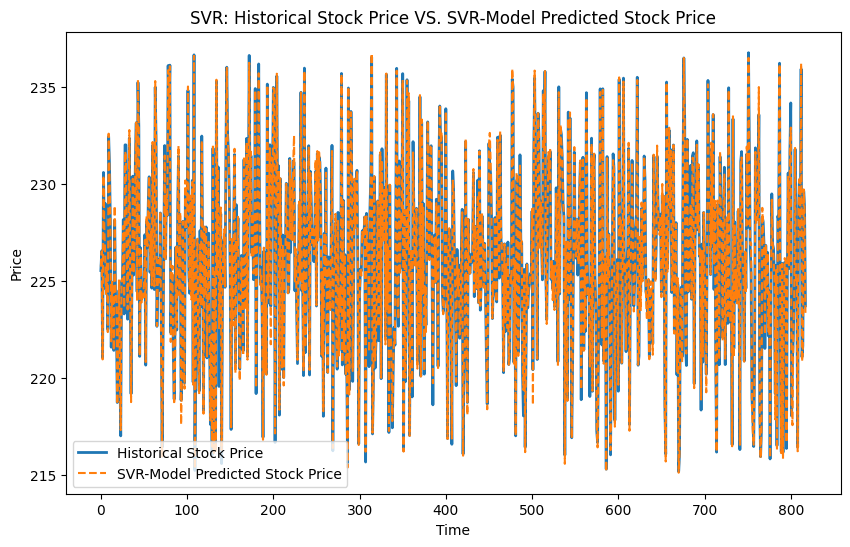

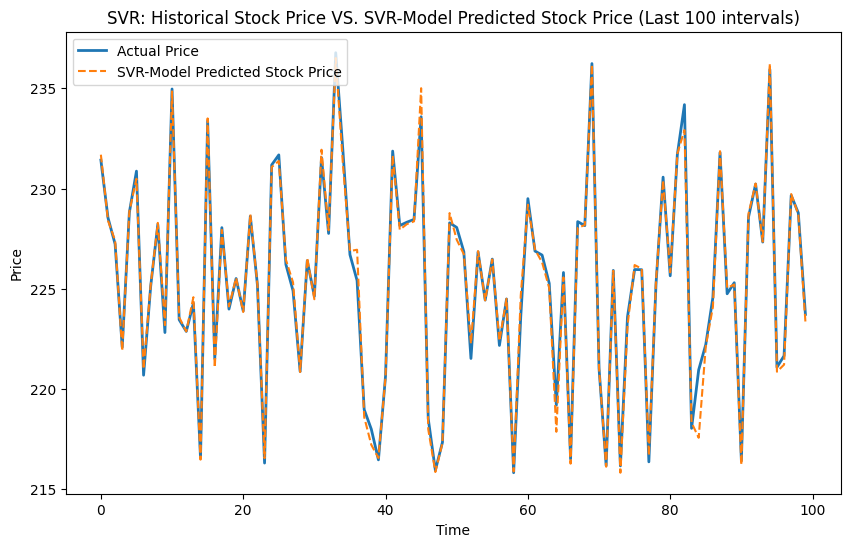

In [13]:
import matplotlib.pyplot as plt

predicted_bucket = os.getenv('PREDICTED_DATA_BUCKET')

variables = {
    'svm_predictions': (predicted_bucket, 'predictions.npy'),
    'svm_original': (predicted_bucket, 'original.npy')
}

variables = load_variables_from_s3(variables)

#Load the appropiate values needed to plot data

svm_predictions = variables['svm_predictions']
svm_original = variables['svm_original']

#Plot two graphs, showcasing the actual and predicted variables, and then, the recent 100 instances.

def plot_actual_vs_predicted_svm(actual, predicted):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Historical Stock Price', linewidth=2)
    plt.plot(predicted, label='SVR-Model Predicted Stock Price', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('SVR: Historical Stock Price VS. SVR-Model Predicted Stock Price')
    plt.legend()
    plt.show()

def plot_actual_vs_predicted_svm_recent(y_test, svm_predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[-100:], label='Actual Price', linewidth=2)
    plt.plot(svm_predictions[-100:], label='SVR-Model Predicted Stock Price', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('SVR: Historical Stock Price VS. SVR-Model Predicted Stock Price (Last 100 intervals)')
    plt.legend()
    plt.show()

plot_actual_vs_predicted_svm(svm_original, svm_predictions)
plot_actual_vs_predicted_svm_recent(svm_original, svm_predictions)

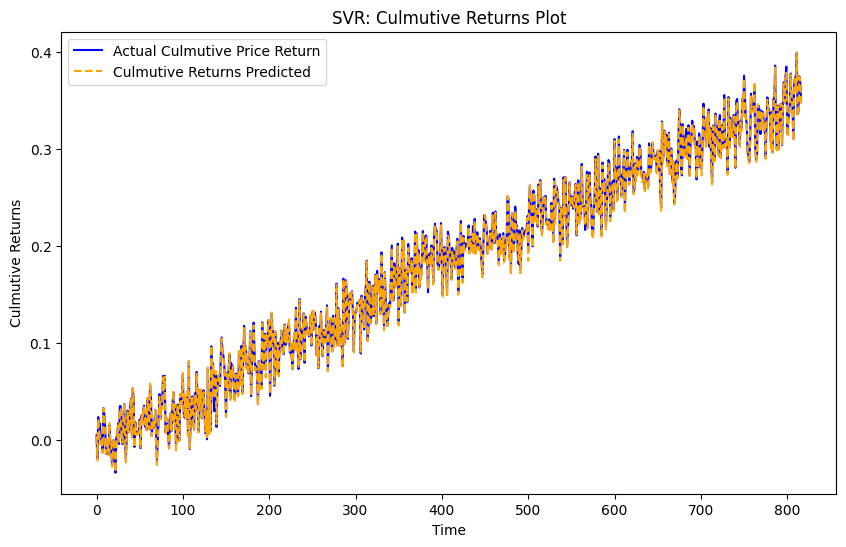

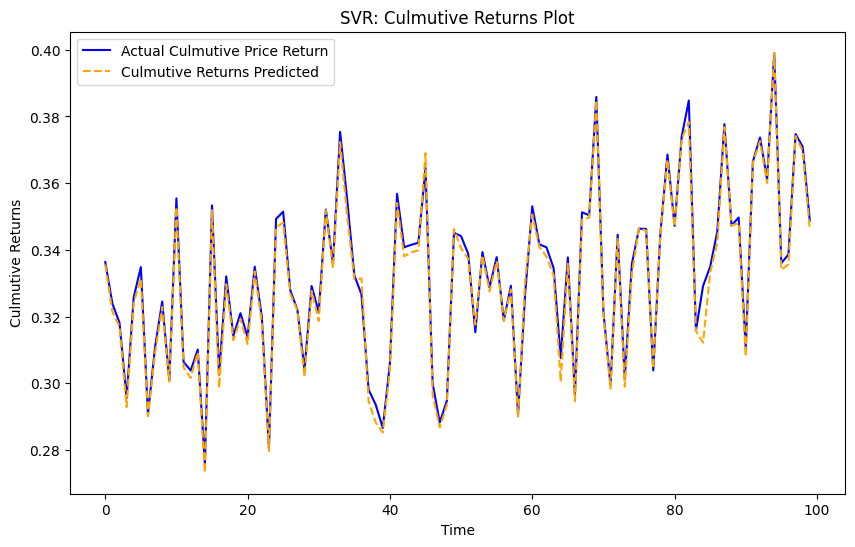

In [14]:
def cumulative_returns(price):
    returns = np.diff(price) / price[:-1]
    return np.cumsum(returns) #The difference between each price against the returns
    
def cumulative_returns_plot(actual, predicted):
    historic_returns = cumulative_returns(svm_y_test)
    returns_predicted = cumulative_returns(predictions)
    plt.figure(figsize=(10, 6))
    plt.plot(historic_returns, label='Actual cumulative Price Return', color='blue')
    plt.plot(returns_predicted, label='cumulative Returns Predicted', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('cumulative Returns')
    plt.title('SVR: cumulative Returns Plot')
    plt.legend()
    plt.show()

def cumulative_returns_plot_recent(actual, predicted):
    historic_returns = cumulative_returns(svm_y_test)
    returns_predicted = cumulative_returns(predictions)
    plt.figure(figsize=(10, 6))
    plt.plot(historic_returns[-100:], label='Actual cumulative Price Return', color='blue')
    plt.plot(returns_predicted[-100:], label='cumulative Returns Predicted', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('cumulative Returns')
    plt.title('SVR: cumulative Returns Plot')
    plt.legend()
    plt.show()

cumulative_returns_plot(svm_original, svm_predictions) #Plot the returns between the predicted and original price
cumulative_returns_plot_recent(svm_original, svm_predictions)

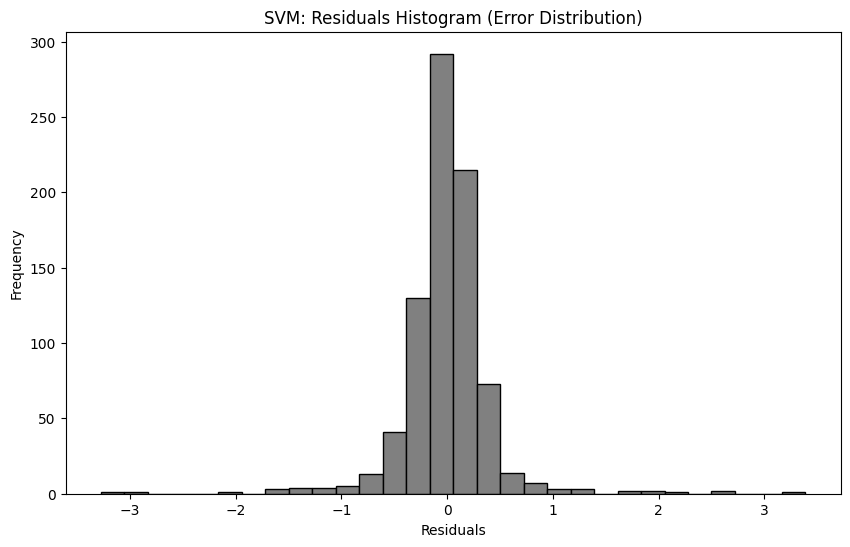

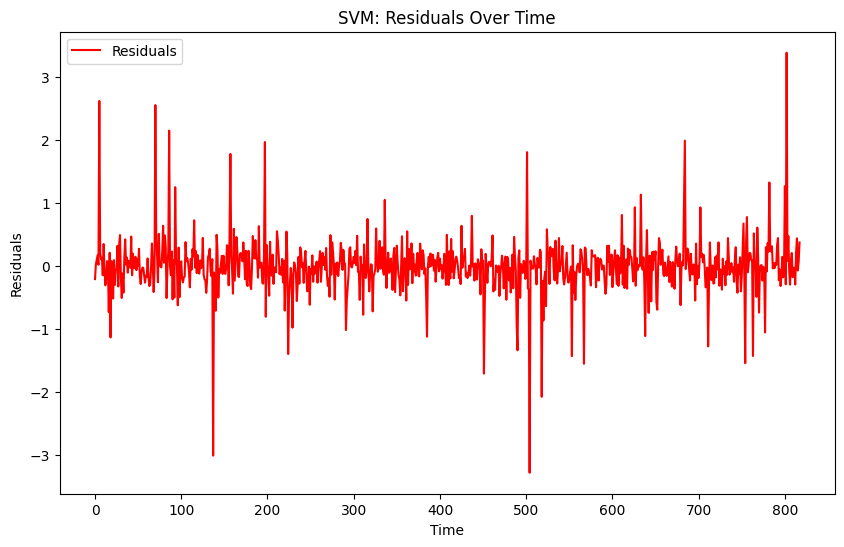

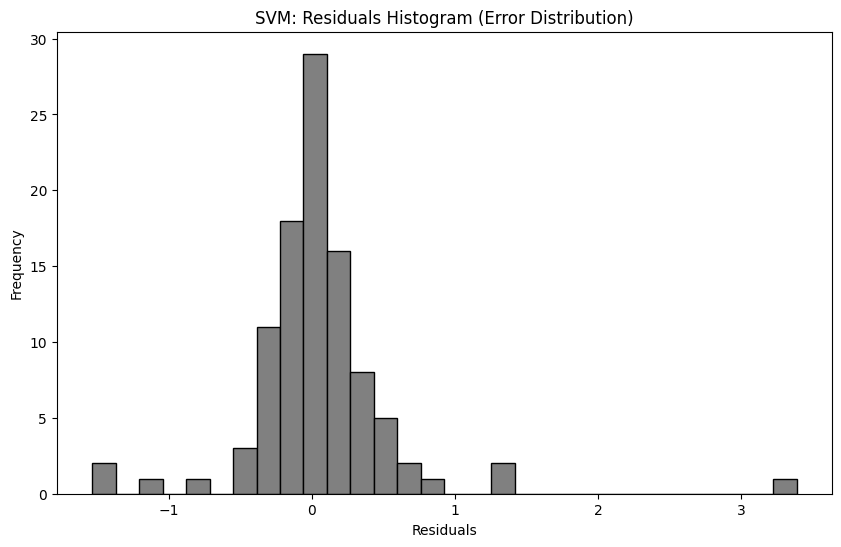

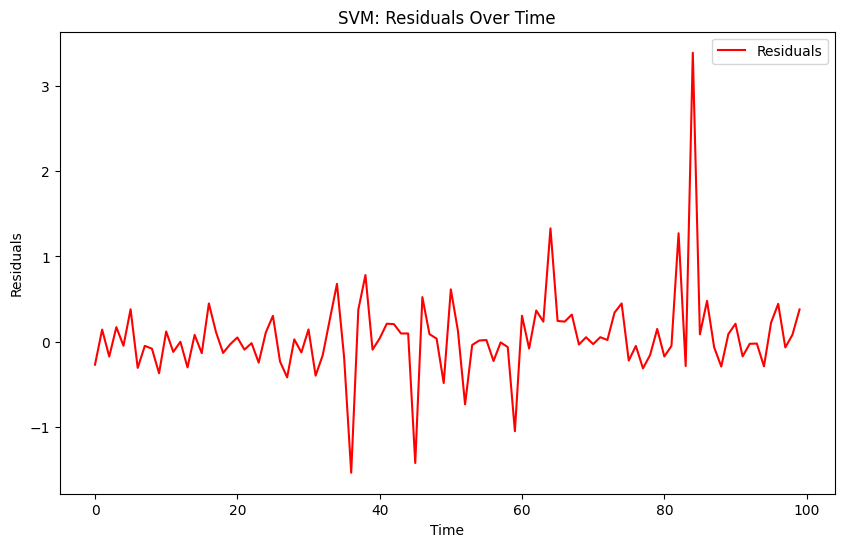

In [15]:
difference = svm_original - svm_predictions

def residuals_hist_and_over_time(residuals):
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, color='gray', edgecolor='black')
    plt.title('SVM: Residuals Histogram (Error Distribution)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='red')
    plt.title('SVM: Residuals Over Time')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

def residuals_hist_and_over_time_recent(residuals):
    plt.figure(figsize=(10, 6))
    plt.hist(residuals[-100:], bins=30, color='gray', edgecolor='black')
    plt.title('SVM: Residuals Histogram (Error Distribution)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(residuals[-100:], label='Residuals', color='red')
    plt.title('SVM: Residuals Over Time')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

#Two types of charts, one being a line chart, and the other being a histogram over the difference between the original and predicted prices.

residuals_hist_and_over_time(difference)
residuals_hist_and_over_time_recent(difference)

In [ ]:
"""

PREDICTING OFF OF DOWNLOADED MODELS: LSTM PREDICTION

"""

In [41]:
import tempfile
from sklearn.metrics import mean_squared_error

ai_bucket = os.getenv('AI_MODEL_DATA_BUCKET')
scaled_bucket = os.getenv('SCALED_DATA_BUCKET')
predicted_bucket = os.getenv('PREDICTED_DATA_BUCKET')

variables = {
    'lstm_train_X': (scaled_bucket, 'lstm_train_X.npy'),
    'lstm_test_X': (scaled_bucket, 'lstm_test_X.npy'),
    'lstm_train_y': (scaled_bucket, 'lstm_train_y.npy'),
    'lstm_test_y': (scaled_bucket, 'lstm_test_y.npy'),
    'lstm_scaler': (ai_bucket, 'lstm_scaler.pkl'),
    'lstm_model': (ai_bucket, 'lstm_model.keras')
}

variables = load_variables_from_s3(variables) #Load the appropiate variables, including the scaler and model

lstm_train_X = variables['lstm_train_X']
lstm_test_X = variables['lstm_test_X']
lstm_train_y = variables['lstm_train_y']
lstm_test_y = variables['lstm_test_y']
lstm_scaler = variables['lstm_scaler']
lstm_model = variables['lstm_model']

predictions = lstm_model.predict(lstm_test_X) #Tie predictions from the test set into the loaded model

prediction_copies_array = np.repeat(predictions, lstm_test_X.shape[2], axis=-1) #Copy the predictions, with 3 features per time step
pred = lstm_scaler.inverse_transform(np.reshape(prediction_copies_array, (len(predictions), lstm_test_X.shape[2])))[:, 0] #Turn away from the scale by inverse transsformation
#Each feature is duplicated to ensure the inverse transformation can be correctly applied, as is below

original_copies_array = np.repeat(lstm_test_y, lstm_test_X.shape[2], axis=-1)
original = lstm_scaler.inverse_transform(np.reshape(original_copies_array, (len(lstm_test_y), lstm_test_X.shape[2])))[:, 0] #Do the same for the original

print("Predicted Values: ", pred) #Print both to check, not needed
print("Original Values: ", original)

prediction_copies_array = np.repeat(predictions, lstm_test_X.shape[2], axis=1) #Predictions and its test shape are repeated to match the number of time steps, and number of features

predicted_price_original_scale = lstm_scaler.inverse_transform(prediction_copies_array)[:, 0] #Transforms the array back to its original scale

print(f"Last input time step: {original[-1]}")
print(f"Predicted next price (original scale): {predicted_price_original_scale[0]}") #Print the redicted next price

mse = mean_squared_error(original, pred)
rmse = np.sqrt(mse) #calculate mse and rmse

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}") #Print

variables = {
        'lstm_predictions': (pred, predicted_bucket, 'lstm_predictions.npy'),
        'lstm_original': (original, predicted_bucket, 'lstm_original.npy')
    }

variables = save_variables_to_s3(variables) #Upload all results

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicted Values:  [228.44643 228.53845 228.61533 228.55528 228.34189 228.49709 228.75441
 228.60468 228.44475 228.67134 228.44156 228.47685 228.51239 228.46617
 228.59518 228.44377 228.53711 228.60439 228.46207 228.47304 228.41876
 228.4418  228.56754 228.38184 228.2972  228.52118 228.5923  228.32425
 228.39128 228.38528 228.61465 228.78488 228.78632 228.86623 228.90048
 228.98306 229.34612 229.2484  228.91199 228.45103 227.90623 228.00835
 227.99576 227.93684 228.06018 227.92978 227.89633 228.20605 228.7038
 228.49136 228.60016 228.68892 228.78989 229.03127 228.71436 228.48225
 228.08475 228.11491 228.2187  228.32614 228.24077 228.02777 227.93674
 228.01918 228.07031 227.7655  227.97798 228.00212 227.84737 227.95209
 228.00963 227.92592 227.89624 227.84685 227.74579 227.87074 227.91408
 227.74251 227.70422 227.6475  227.71237 227.93521 227.87413 227.80693
 227.6167  227.71706 227.80367 227.76093 227.72891 227.73834 227.78006
 227.84824 227.85797

In [43]:
new_metrics_entry = create_metrics_csv(mse, rmse, predicted_price_original_scale[0])

bucket_name, s3_filename = predicted_bucket, 'lstm_logged_metrics.csv'

update_metrics_on_s3(bucket_name, s3_filename, new_metrics_entry) #Save predictions and other metrics

In [ ]:
"""

MODEL GRAPHS: LSTM

"""

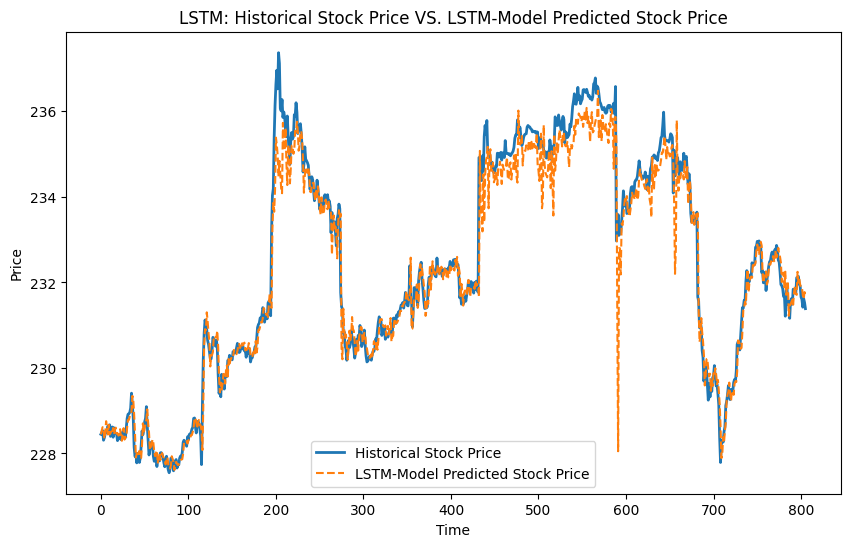

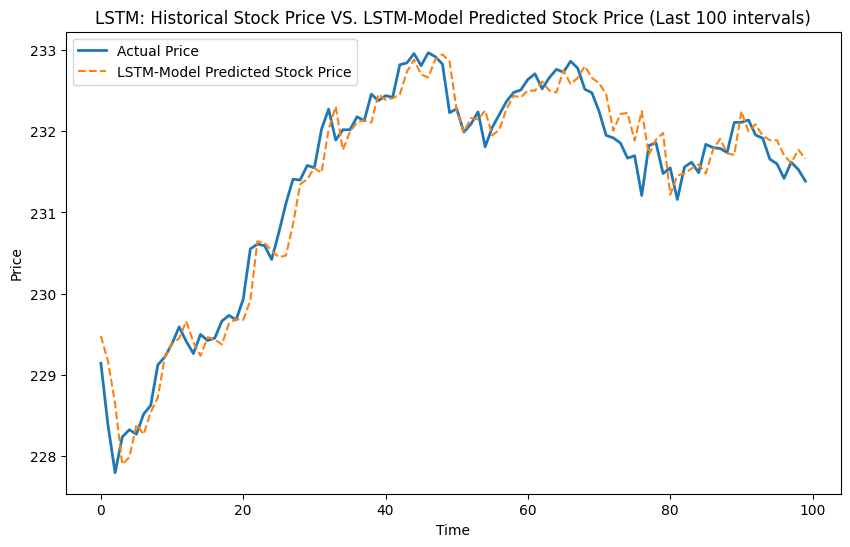

In [20]:
import matplotlib.pyplot as plt

predicted_bucket = os.getenv('PREDICTED_DATA_BUCKET')

variables = {
    'lstm_predictions': (predicted_bucket, 'lstm_predictions.npy'),
    'lstm_original': (predicted_bucket, 'lstm_original.npy')
}

variables = load_variables_from_s3(variables)

lstm_original = variables['lstm_original']
lstm_predictions = variables['lstm_predictions']

def plot_actual_vs_predicted_lstm(y_test, lstm_predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Historical Stock Price', linewidth=2)
    plt.plot(lstm_predictions, label='LSTM-Model Predicted Stock Price', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('LSTM: Historical Stock Price VS. LSTM-Model Predicted Stock Price')
    plt.legend()
    plt.show()

def plot_actual_vs_predicted_lstm_recent(y_test, lstm_predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[-100:], label='Actual Price', linewidth=2)
    plt.plot(lstm_predictions[-100:], label='LSTM-Model Predicted Stock Price', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('LSTM: Historical Stock Price VS. LSTM-Model Predicted Stock Price (Last 100 intervals)')
    plt.legend()
    plt.show()

plot_actual_vs_predicted_lstm(lstm_original, lstm_predictions) #Plot the original and predicted variables
plot_actual_vs_predicted_lstm_recent(lstm_original, lstm_predictions) #Recent 100 intervals

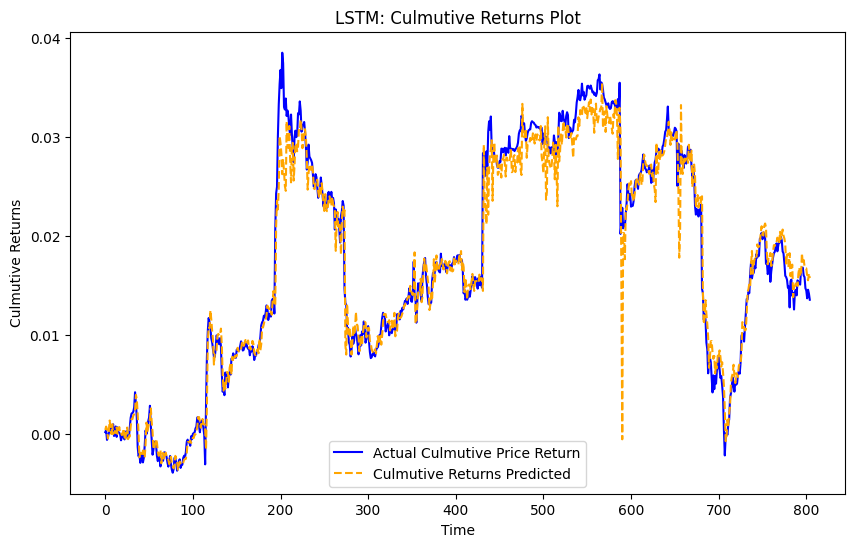

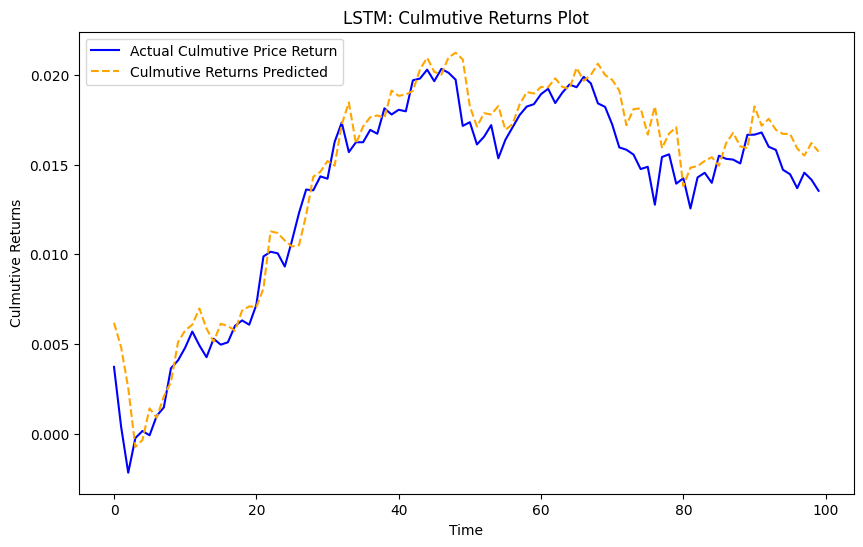

In [21]:
import matplotlib.pyplot as plt

def cumulative_returns(price):
    returns = np.diff(price) / price[:-1]
    return np.cumsum(returns)
    
def lstm_cumulative_returns_plot(lstm_test_y, pred):
    historic_returns = cumulative_returns(lstm_test_y)
    returns_predicted = cumulative_returns(pred)
    plt.figure(figsize=(10, 6))
    plt.plot(historic_returns, label='Actual cumulative Price Return', color='blue')
    plt.plot(returns_predicted, label='cumulative Returns Predicted', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('cumulative Returns')
    plt.title('LSTM: cumulative Returns Plot')
    plt.legend()
    plt.show()

def lstm_cumulative_returns_plot_recent(lstm_test_y, pred):
    historic_returns = cumulative_returns(lstm_test_y)
    returns_predicted = cumulative_returns(pred)
    plt.figure(figsize=(10, 6))
    plt.plot(historic_returns[-100:], label='Actual cumulative Price Return', color='blue')
    plt.plot(returns_predicted[-100:], label='cumulative Returns Predicted', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('cumulative Returns')
    plt.title('LSTM: cumulative Returns Plot')
    plt.legend()
    plt.show()

lstm_cumulative_returns_plot(lstm_original, lstm_predictions)#Cumulative gains and loss for the original against predicted
lstm_cumulative_returns_plot_recent(lstm_original, lstm_predictions)#Last 100

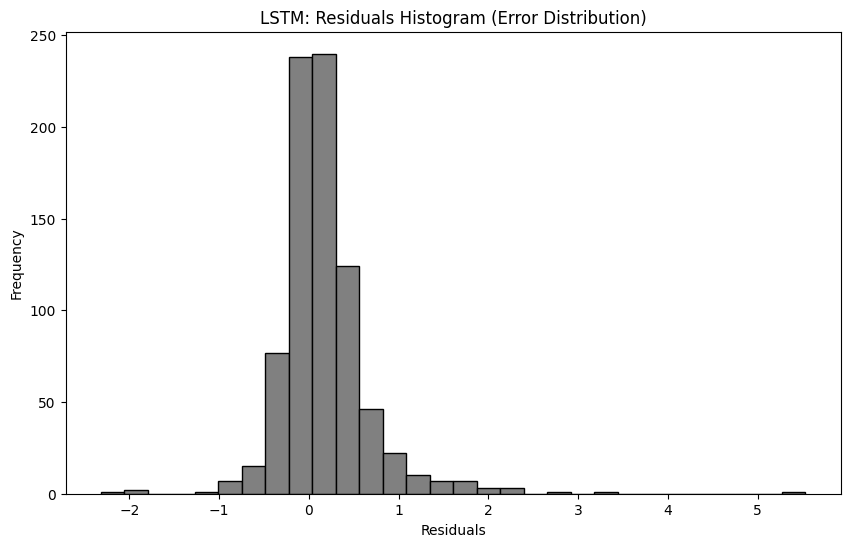

In [22]:
difference = lstm_original - lstm_predictions

def plot_diff_lstm(residuals):
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, color='gray', edgecolor='black')
    plt.title('LSTM: Residuals Histogram (Error Distribution)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

plot_diff_lstm(difference) #Histogram to showcase residual errors

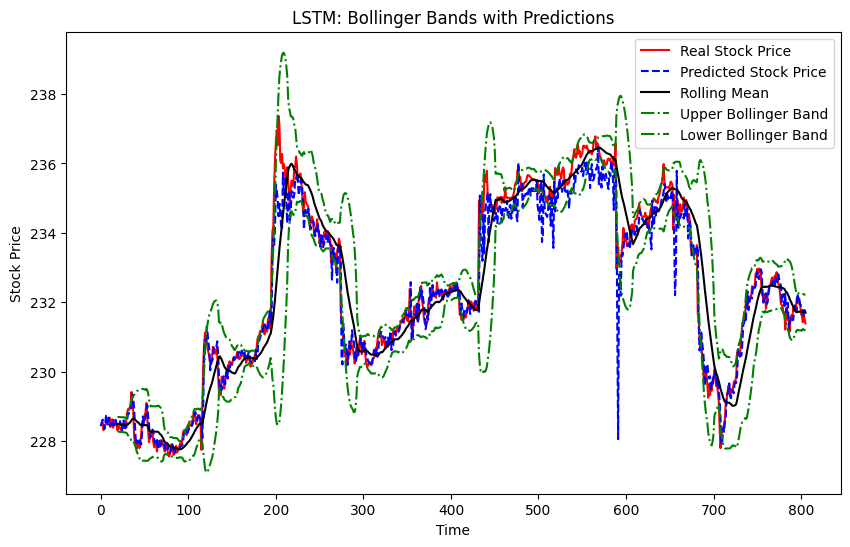

In [23]:
def bollinger_bands(df):
    rolling_mean = pd.Series(df).rolling(window=8).mean()
    rolling_std = pd.Series(df).rolling(window=8).std()
    upper_band = rolling_mean + (2 * rolling_std)
    lower_band = rolling_mean - (2 * rolling_std)
    return rolling_mean, upper_band, lower_band

rolling_mean, upper_band, lower_band = bollinger_bands(lstm_original)

def plot_bollinger_against_predictions(actual, predicted, rolling_mean, upper_band, lower_band):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Real Stock Price', color='red')
    plt.plot(predicted, label='Predicted Stock Price', linestyle='--', color='blue')
    plt.plot(rolling_mean, label='Rolling Mean', color='black')
    plt.plot(upper_band, label='Upper Bollinger Band', linestyle='-.', color='green')
    plt.plot(lower_band, label='Lower Bollinger Band', linestyle='-.', color='green')
    plt.title('LSTM: Bollinger Bands with Predictions')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

plot_bollinger_against_predictions(lstm_original, lstm_predictions, rolling_mean, upper_band, lower_band)#Bollinger bands assigned to 
#produce graph which compares real against predicted, between upper and lower bollinger bands with a rolling mean

In [ ]:
"""

RANDOMFORESTMODEL RETRAINING PIPELINE

"""

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import joblib

ai_bucket = os.getenv('AI_MODEL_DATA_BUCKET')
scaled_bucket = os.getenv('SCALED_DATA_BUCKET')
processed_bucket = os.getenv('PROCESSED_DATA_BUCKET')
predicted_bucket = os.getenv('PREDICTED_DATA_BUCKET')

variables = {
    'future_data': (processed_bucket, 'processed_aapl_stock.csv')
}

loaded_variables = load_variables_from_s3(variables)

future_data = loaded_variables['future_data'] #Load in dataframe

predictors = ['Relative Strength Index', '%K Fast', '%D Slow',
       'Williams R%', 'Close_To_moving_AVG', 'Price Rate of Change',
       'On Balance Volume'] #Set predictors

def evaluate_model(preds, model, data, predictors): #Function evaluates the performance of the model
    cv_scores_5 = cross_val_score(model, data[predictors], data['Target'], cv=5, scoring='precision')
    print(f"5-fold Cross-validated Precision Score: {cv_scores_5.mean()}")
    cv_scores_10 = cross_val_score(model, data[predictors], data['Target'], cv=10, scoring='precision')
    print(f"10-fold Cross-validated Precision Score: {cv_scores_10.mean()}")

model = RandomForestClassifier( #Define model attributes
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=300,
    random_state=42
)

def financial_gain(test, predictions, initial_capital=10000): 
    #Copy
    test = test.copy()  
    #Add preds to test data
    test.loc[:, 'Predictions'] = predictions['Predictions']  
    #Calc % in close price
    test.loc[:, 'Daily Return'] = test['Close'].pct_change()  
    #Shift one day, avoid biased
    test.loc[:, 'Predictions'] = test['Predictions'].shift(1)  
    #Drop missing val rows
    test = test.dropna(subset=["Predictions", "Daily Return"])  

    #Define positions
    #1 = Buy
    #0 = Sell
    #2 = Hold
    test.loc[:, 'Position'] = test['Predictions'].replace({2: 0})  #Hold is no action
    
    #Calculate the strategy's return
    #Daily ret for buy
    #No ret if hold or sell
    test.loc[:, 'Strategy Return'] = test['Position'] * test['Daily Return']  
    
    #Calc cumulative returns for both strats
    test.loc[:, 'Cumulative Market Return'] = (1 + test['Daily Return']).cumprod() - 1
    test.loc[:, 'Cumulative Strategy Return'] = (1 + test['Strategy Return']).cumprod() - 1  
    
    #Get the final cumulative returns
    final_strategy_return = test['Cumulative Strategy Return'].iloc[-1]
    final_market_return = test['Cumulative Market Return'].iloc[-1]

    # Calculate the total profits
    total_strategy_profit = initial_capital * (1 + final_strategy_return)
    total_market_profit = initial_capital * (1 + final_market_return)

    # Print the profits for both strategies
    print(f"Total Strategy Profit: ${total_strategy_profit - initial_capital:.2f}")
    print(f"Total Market (Buy and Hold) Profit: ${total_market_profit - initial_capital:.2f}")

    return test

def predict_prob(train, test, predictors, model):
    model.fit(train[predictors], train["Target"]) #Train the model for the target
    preds = model.predict_proba(test[predictors])[:, 1] #Returns the probability of 0-1
    preds = np.where(preds >= 0.6, 1, np.where(preds <= 0.4, 0, 2)) #Of which then depending on confidence is assigned a buy 1, sell 0
    #Hold is 2
    preds = pd.Series(preds, index=test.index, name="Predictions") #Then store in preds as pd and combine with target to return merged actual v predicted
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, train_ratio=0.8):
    all_preds = [] #Store all predicted values 
    row_count = future_data.shape[0] #Row number in data 
    training_set = int(train_ratio*row_count) #Grab the training ratio agains the row count 
    train = future_data.iloc[:training_set].copy()
    test = future_data.iloc[training_set:].copy() #Establish training and test datasets
    pred = predict_prob(train, test, predictors, model) #Call predict_prob to find buy sell or hold variables
    results = financial_gain(test, pred) #Use the results from financial_gain to predict the profit
    all_preds.append(results) #Append and output
    return pd.concat(all_preds)

preds = backtest(future_data, model, predictors)

evaluate_model(preds, model, future_data, predictors) #Grab model performance

variables = {
        'rf_model': (model, ai_bucket, 'rf_model.pkl')
    }

variables = save_variables_to_s3(variables)

print("Model saved successfully!")

Total Strategy Profit: $128.72
Total Market (Buy and Hold) Profit: $118.77
5-fold Cross-validated Precision Score: 0.5038295186188904
10-fold Cross-validated Precision Score: 0.48987337034491185
Model saved successfully!


In [ ]:
"""

RANDOMFORESTMODEL PREDICTION

"""

In [36]:
import joblib
import boto3
from io import BytesIO
import pandas as pd

variables = {
    'rf_model': (ai_bucket, 'rf_model.pkl'),
    'future_data': (processed_bucket, 'processed_aapl_stock.csv')
}

loaded_variables = load_variables_from_s3(variables) #load appropiate variables
rf_model = loaded_variables['rf_model']
future_data = loaded_variables['future_data']
future_data = future_data.sort_index(ascending=True) #sort the index by ascending of future data to get needed order

def prepare_next_interval_features(data, predictors):
    if len(data) == 0:
        raise ValueError("No data available to predict the next interval.") #If there is no data, error
    latest_data = data[predictors].iloc[[-1]] #Or else, grab the last row
    return latest_data

def predict_next_interval(data, model, predictors, threshold=0.6):
    next_interval_features = prepare_next_interval_features(data, predictors) #Predict the next interval
    pred_proba = model.predict_proba(next_interval_features)[:, 1] #Use the model to predict AFTER the last row based off
    return "Buy" if pred_proba >= threshold else "Sell" #of rf_model if the next period is  buy or sell, then return

predictors = ['Relative Strength Index', '%K Fast', '%D Slow',
              'Williams R%', 'Close_To_moving_AVG', 'Price Rate of Change',
              'On Balance Volume'] #Grab appropiate predictors

next_prediction = predict_next_interval(future_data, rf_model, predictors) #call the predictor interval

print(f"Next 5-minute interval prediction: {next_prediction}")

Next 5-minute interval prediction: Buy
